# Laboratorio 3: Cuociente carga/masa del electrón

- Camila Ferrus
- Marcelo Ojeda

In [181]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
import numpy as np
import astropy.constants as const
import astropy.units as u
import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)
from scipy.optimize import minimize, curve_fit
from scipy.stats import chi2
from sklearn.metrics import mean_squared_error

## Marco teórico

$$\frac{e}{m} = \frac{2V}{B^{2}r^{2}}\left[\frac{C}{kg}\right] \tag{6}$$

- $e$: Carga del electrón
- $m$: Masa del electrón
- $V$: Voltaje de aceleración del electrón
- $B$: Campo magnético donde se encuentra el electrón
- $r$: Radio de curvatura del recorrido del electrón

Un campo magnético estático y homogéneo puede ser generado en el interior de una bobina larga, por la cual circula una corriente estacionaria $I$. En estas condiciones el campo es paralelo al eje de la bobina y está dado por:

$$B = \mu_{0}NI \tag{7}$$

donde $\mu_{0} = 1.26 \cdot 10^{-6} \text{H/m}$ es la permitividad del vacío, $I$ es la corriente que circula por la bobina, y $N$ es el número de vueltas por unidad de longitud de la bobina.

Combinando las ecuaciones $(6)$ y $(7)$, se puede plantear una función que modele el radio de curvatura del recorrido del electrón con respecto a la corriente, donde la pendiente de esa ecuación sea el cuociente masa-carga del electrón:

$$I^{2}\frac{e}{m} = \frac{2V}{\mu_{0}^{2}N^{2}r^{2}}$$

- Valor de tabla: $e/m = 1.76 \cdot 10^{11} \text{C/kg}$ 

In [96]:
radio_tubo_ext_pix = 1218.721 # px
radio_tubo_ext_mm = 25.55 / 2 # mm

radio_tubo_int_pix = 505.729 # px
radio_tubo_int_mm = 6.45 / 2 # mm

len_bobina = 135.00 # mm
vueltas_bobina = 710
vueltas_por_largo_sq = (vueltas_bobina / (len_bobina * u.mm).to(u.m).value) ** 2 # m^-2
vueltas_por_largo_sq_err = 2 * ((vueltas_bobina ** 2) / ((len_bobina * u.mm).to(u.m).value ** 3)) * (err_piedemetro* u.mm).to(u.m).value # m^-2

voltaje_constante = 149.1 # V
doble_voltaje_constante = 2 * voltaje_constante # V

permeabilidad_vacio_hm = const.mu0.to(u.H /  u.m).value # H/m

err_pix = 0.0005 # px
err_piedemetro = 0.025 # mm
err_v = 0.05 # V
err_A = 0.005 # A 

In [107]:
imagenes = os.listdir('Imagenes')[:-1]
imagenes

['0.48A_1605.386.jpg',
 '1.0A_982.466.jpg',
 '1.3A_553.414.jpg',
 '1.8A_448.507.jpg',
 '2.0A_434.201.jpg',
 '2.3A_345.984.jpg',
 '2.5A_343.458.jpg',
 '2.7A_323.175.jpg',
 '2.9A_314.160.jpg',
 '3.0A_311.906.jpg',
 '3.2A_298.299.jpg',
 '3.4A_291.146.jpg',
 '3.5A_286.378.jpg',
 '3.7A_279.225.jpg',
 '3.9A_274.456.jpg',
 '4.0A_264.919.jpg',
 '4.2A_255.382.jpg',
 '4.3A_241.077.jpg',
 '5.0A_191.008.jpg']

In [98]:
imagenes_data = pd.DataFrame()
corrientes = list()
radios_curv_pix = list()

for filename in imagenes:
    data_filename = filename.strip('.jpg').split('A_')
    corriente = float(data_filename[0])
    radio_curv_pix = float(data_filename[1])
    
    corrientes.append(corriente)
    radios_curv_pix.append(radio_curv_pix)

imagenes_data['I_A'] = corrientes
imagenes_data['err_I_A'] = [err_A for i in corrientes]
imagenes_data['I^2_A^2'] = np.array(corrientes) ** 2
imagenes_data['err_I^2_A^2'] = [2 * i * err_A for i in corrientes]
imagenes_data['r_pix'] = radios_curv_pix
imagenes_data['err_r_pix'] = [err_pix for i in corrientes]

imagenes_data

,I_A,err_I_A,I^2_A^2,err_I^2_A^2,r_pix,err_r_pix
0,0.48,0.005,0.2304,0.0048,1605.386,0.0005
1,1.00,0.005,1.0000,0.0100,982.466,0.0005
2,1.30,0.005,1.6900,0.0130,553.414,0.0005
3,1.80,0.005,3.2400,0.0180,448.507,0.0005
4,2.00,0.005,4.0000,0.0200,434.201,0.0005
5,2.30,0.005,5.2900,0.0230,345.984,0.0005
6,2.50,0.005,6.2500,0.0250,343.458,0.0005
7,2.70,0.005,7.2900,0.0270,323.175,0.0005
8,2.90,0.005,8.4100,0.0290,314.160,0.0005
9,3.00,0.005,9.0000,0.0300,311.906,0.0005


In [99]:
def conversion_pix_a_mm(r_ext_pix, r_ext_mm, r_pix, err_pix, err_mm):
    r_mm = (r_pix * r_ext_mm) / r_ext_pix
    err_r_mm = np.sqrt(((r_ext_mm / r_ext_pix) * err_pix) ** 2 +
                       ((r_pix / r_ext_pix) * err_mm) ** 2 +
                       ((- (r_pix * r_ext_mm) / (r_ext_pix **2)) * err_pix) ** 2)
    
    return r_mm, err_r_mm

In [100]:
radios_mm, err_radios_mm = conversion_pix_a_mm(radio_tubo_ext_pix,
                                               radio_tubo_ext_mm,
                                               imagenes_data['r_pix'],
                                               imagenes_data['err_r_pix'],
                                               err_piedemetro)

radios_mm_sq = np.array(radios_mm) ** 2
radios_mm_sq_err = 2 * np.array(radios_mm) * err_piedemetro

imagenes_data['r_m'] = (np.array(radios_mm) * u.mm).to(u.m).value
imagenes_data['err_r_m'] = (np.array(err_radios_mm) * u.mm).to(u.m).value
imagenes_data['r^2_m^2'] = (np.array(radios_mm_sq) * u.mm**2).to(u.m**2).value
imagenes_data['err_r^2_m^2'] = (np.array(radios_mm_sq_err) * u.mm**2).to(u.m**2).value
imagenes_data

,I_A,err_I_A,I^2_A^2,err_I^2_A^2,r_pix,err_r_pix,r_m,err_r_m,r^2_m^2,err_r^2_m^2
0,0.48,0.005,0.2304,0.0048,1605.386,0.0005,0.016828,0.000033,0.000283,8.414069e-07
1,1.00,0.005,1.0000,0.0100,982.466,0.0005,0.010299,0.000020,0.000106,5.149252e-07
2,1.30,0.005,1.6900,0.0130,553.414,0.0005,0.005801,0.000011,0.000034,2.900526e-07
3,1.80,0.005,3.2400,0.0180,448.507,0.0005,0.004701,0.000009,0.000022,2.350693e-07
4,2.00,0.005,4.0000,0.0200,434.201,0.0005,0.004551,0.000009,0.000021,2.275713e-07
5,2.30,0.005,5.2900,0.0230,345.984,0.0005,0.003627,0.000007,0.000013,1.813354e-07
6,2.50,0.005,6.2500,0.0250,343.458,0.0005,0.003600,0.000007,0.000013,1.800115e-07
7,2.70,0.005,7.2900,0.0270,323.175,0.0005,0.003388,0.000007,0.000011,1.693809e-07
8,2.90,0.005,8.4100,0.0290,314.160,0.0005,0.003293,0.000006,0.000011,1.646560e-07
9,3.00,0.005,9.0000,0.0300,311.906,0.0005,0.003269,0.000006,0.000011,1.634746e-07


In [101]:
def factor_curvatura(doble_voltaje, permeabilidad_vacio, vueltas_por_largo_sq, radio_sq,
                     err_volt, err_vueltas_sq, err_radio_sq):
    
    curvatura = doble_voltaje / ((permeabilidad_vacio ** 2) * vueltas_por_largo_sq * radio_sq)
    
    err_asoc_voltaje = (2 / ((permeabilidad_vacio ** 2) * vueltas_por_largo_sq * radio_sq)) * err_volt
    err_asoc_vueltas = (-1 * doble_voltaje / ((permeabilidad_vacio ** 2) * (vueltas_por_largo_sq ** 2) * radio_sq)) * err_vueltas_sq
    err_asoc_radio = (-1 * doble_voltaje / ((permeabilidad_vacio ** 2) * vueltas_por_largo_sq * (radio_sq ** 2))) * err_radio_sq
    
    err_curvatura = np.sqrt((err_asoc_voltaje ** 2) + (err_asoc_vueltas ** 2) + (err_asoc_radio ** 2))
    
    return curvatura, err_curvatura

In [102]:
curvatura, err_factor_curvatura = factor_curvatura(doble_voltaje_constante, permeabilidad_vacio_hm, vueltas_por_largo_sq, imagenes_data['r^2_m^2'],
                                                          err_v, vueltas_por_largo_sq_err, imagenes_data['err_r^2_m^2'])

imagenes_data['curvatura'] = curvatura
imagenes_data['err_curvatura'] = err_factor_curvatura
imagenes_data

,I_A,err_I_A,I^2_A^2,err_I^2_A^2,r_pix,err_r_pix,r_m,err_r_m,r^2_m^2,err_r^2_m^2,curvatura,err_curvatura
0,0.48,0.005,0.2304,0.0048,1605.386,0.0005,0.016828,0.000033,0.000283,8.414069e-07,2.410830e+10,7.263660e+07
1,1.00,0.005,1.0000,0.0100,982.466,0.0005,0.010299,0.000020,0.000106,5.149252e-07,6.437103e+10,3.141766e+08
2,1.30,0.005,1.6900,0.0130,553.414,0.0005,0.005801,0.000011,0.000034,2.900526e-07,2.028735e+11,1.751527e+09
3,1.80,0.005,3.2400,0.0180,448.507,0.0005,0.004701,0.000009,0.000022,2.350693e-07,3.088781e+11,3.288592e+09
4,2.00,0.005,4.0000,0.0200,434.201,0.0005,0.004551,0.000009,0.000021,2.275713e-07,3.295671e+11,3.624225e+09
5,2.30,0.005,5.2900,0.0230,345.984,0.0005,0.003627,0.000007,0.000013,1.813354e-07,5.190551e+11,7.160706e+09
6,2.50,0.005,6.2500,0.0250,343.458,0.0005,0.003600,0.000007,0.000013,1.800115e-07,5.267181e+11,7.319794e+09
7,2.70,0.005,7.2900,0.0270,323.175,0.0005,0.003388,0.000007,0.000011,1.693809e-07,5.949083e+11,8.785659e+09
8,2.90,0.005,8.4100,0.0290,314.160,0.0005,0.003293,0.000006,0.000011,1.646560e-07,6.295406e+11,9.563597e+09
9,3.00,0.005,9.0000,0.0300,311.906,0.0005,0.003269,0.000006,0.000011,1.634746e-07,6.386723e+11,9.772358e+09


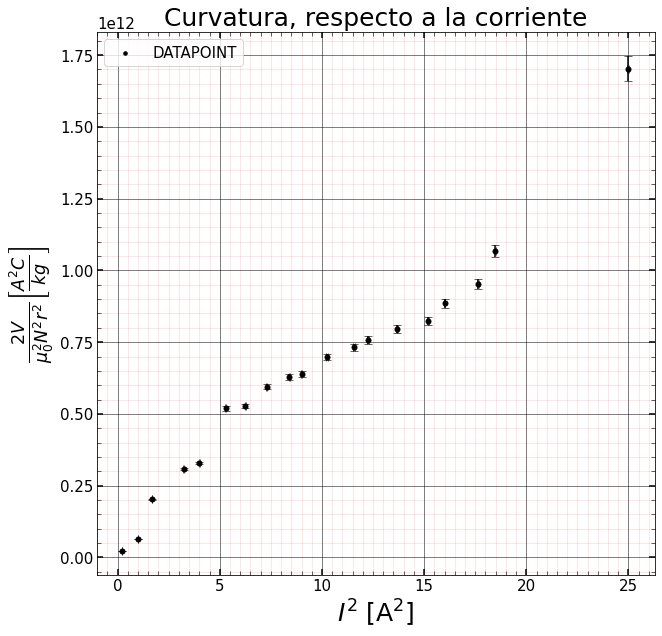

In [126]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(imagenes_data['I^2_A^2'], imagenes_data['curvatura'], xerr = imagenes_data['err_I^2_A^2'], yerr = imagenes_data['err_curvatura'],
              fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(imagenes_data['I^2_A^2'], imagenes_data['curvatura'], marker=".", s=50, c="black", label='DATAPOINT')
ax1.set_title('Curvatura, respecto a la corriente', fontsize=25)
ax1.set_ylabel(r'$\frac{2V}{\mu_{0}^{2}N^{2}r^{2}} \left[\frac{A^{2}C}{kg}\right]$', fontsize=25)
ax1.set_xlabel(r'$I^{2}$ [A$^{2}$]', fontsize=25)
ax1.yaxis.get_offset_text().set_fontsize(15)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(MultipleLocator(50000000000))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

In [104]:
def modelo_em(corriente_sq, masa_carga_e):
    return corriente_sq * masa_carga_e

In [174]:
popt, pcov = curve_fit(modelo_em, imagenes_data['I^2_A^2'], imagenes_data['curvatura'], p0=[10 ** 11])
popt

array([6.27240734e+10])

In [175]:
def err_mc_electron(corriente_sq, masa_carga_e, err_curvatura, err_corriente_sq):
    return np.sqrt(((err_curvatura ** 2) - ((masa_carga_e * err_corriente_sq) ** 2)) / (corriente_sq ** 2))

In [178]:
err_mc = np.mean(err_mc_electron(imagenes_data['I^2_A^2'], popt[0], imagenes_data['err_curvatura'], imagenes_data['err_I^2_A^2']))
np.array(err_mc)

c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


array(1.08172416e+09)

In [191]:
err_porcentual = (err_mc * 100) / popt[0]

In [159]:
curvatura_con_ajuste = np.array(modelo_em(imagenes_data['I^2_A^2'], popt[0]))
curvatura_observada = np.array(imagenes_data['curvatura'])

In [ ]:
chisq_ma = np.sum((datos_obtenidos - datos_modelo_ma)**2/(datos['Radial_Velocity_Uncertainty'])**2)

In [169]:
residuals = curvatura_observada - curvatura_con_ajuste
squared_diff = residuals ** 2
chi_squared = np.sum(squared_diff)
df = len(curvatura_con_ajuste) - 2
chisq_dof = (1./df) * chi_squared
p_value = 1 - chi2.cdf(chi_squared, df)
chisq_dof

1.1927421304593057e+22

In [167]:
mse = mean_squared_error(curvatura_observada, curvatura_con_ajuste)
rmse = np.sqrt(mse)
print(f'{rmse:.3e}')

1.033e+11


In [168]:
pear, _ = pearsonr(curvatura_observada, curvatura_con_ajuste)
pear

0.9720225249074756

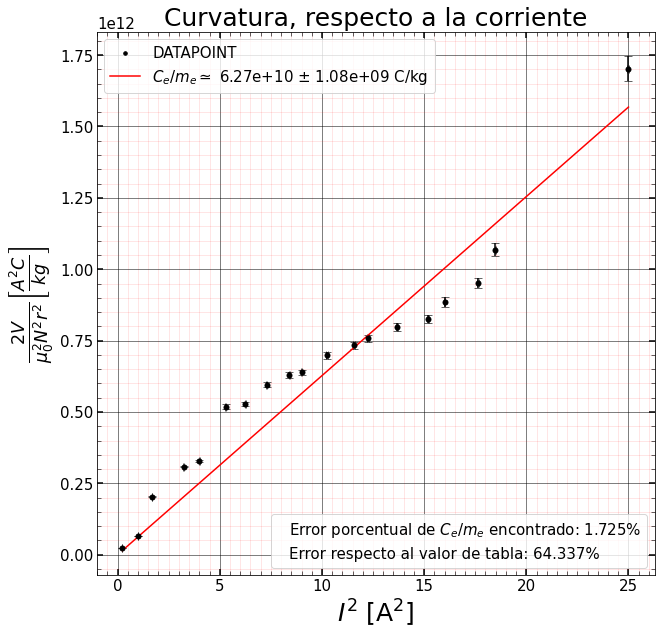

In [233]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(imagenes_data['I^2_A^2'], imagenes_data['curvatura'], xerr = imagenes_data['err_I^2_A^2'], yerr = imagenes_data['err_curvatura'],
              fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(imagenes_data['I^2_A^2'], imagenes_data['curvatura'], marker=".", s=50, c="black", label='DATAPOINT')
ax1.plot(imagenes_data['I^2_A^2'], modelo_em(imagenes_data['I^2_A^2'], popt), c='r',label=r'$C_e/m_e \simeq$ {:.2e} ± {:.2e} C/kg'.format(popt[0], err_mc))
ax1.set_title('Curvatura, respecto a la corriente', fontsize=25)
ax1.set_ylabel(r'$\frac{2V}{\mu_{0}^{2}N^{2}r^{2}} \left[\frac{A^{2}C}{kg}\right]$', fontsize=25)
ax1.set_xlabel(r'$I^{2}$ [A$^{2}$]', fontsize=25)
ax1.yaxis.get_offset_text().set_fontsize(15)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

extra_legend_1 = mpatches.Patch(label=r'Error porcentual de $C_e/m_e$ encontrado: {:.3f}%'.format(err_porcentual))
extra_legend_2 = mpatches.Patch(label=r'Error respecto al valor de tabla: {:.3f}%'.format(err_porcentual_tabla))
handles, labels = ax1.get_legend_handles_labels()
handles.append(extra_legend_1)
handles.append(extra_legend_2)
extra_legend = ax1.legend(handles=[extra_legend_1, extra_legend_2], loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)
extra_legend.legendHandles[1].set_visible(False)
ax1.add_artist(extra_legend)

ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(MultipleLocator(50000000000))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(handles=handles, labels=labels, fontsize=15)